In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
sns.set()

# Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15-minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [2]:
logins = pd.read_json('logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


data starts Thursday, 1/1/1970 at 8:13:18 PM; missing data prior to this time.

In [3]:
logins.tail()

,login_time
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38
93141,1970-04-13 18:54:23


Data ends Monday, 4/13/1970 at 6:54:23 PM; missing data after this time

In [4]:
logins.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [5]:
buckets = logins.resample(rule='15Min', on='login_time').count()
buckets.columns = ['count']

In [6]:
buckets.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
count    9788 non-null int64
dtypes: int64(1)
memory usage: 152.9 KB


In [7]:
buckets.describe()

,count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


In [8]:
len(buckets) - len(buckets.loc[buckets['count'] > 0])

407

407 entries with 0 logins

In [9]:
# off peak hours, under 75th percentile/13 logins
off_peak = buckets.loc[buckets['count'] < 13]

In [10]:
off_peak.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7096 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Data columns (total 1 columns):
count    7096 non-null int64
dtypes: int64(1)
memory usage: 110.9 KB


In [11]:
off_peak_counts = pd.Series(off_peak.index.time).value_counts().sort_index()

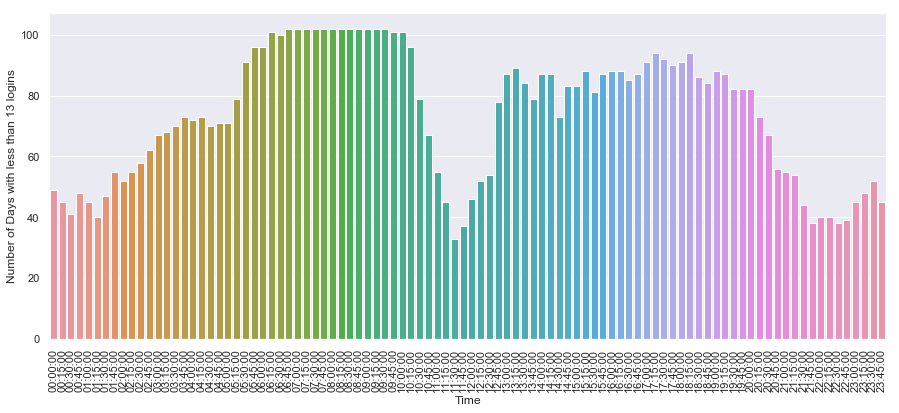

In [12]:
plt.figure(figsize=(15,6))
sns.barplot(off_peak_counts.index, off_peak_counts.values)
plt.xticks(rotation=90)
plt.xlabel('Time')
plt.ylabel('Number of Days with less than 13 logins')
plt.show()

In [13]:
peak = buckets.loc[buckets['count'] >= 13]

In [14]:
peak_counts = pd.Series(peak.index.time).value_counts().sort_index()

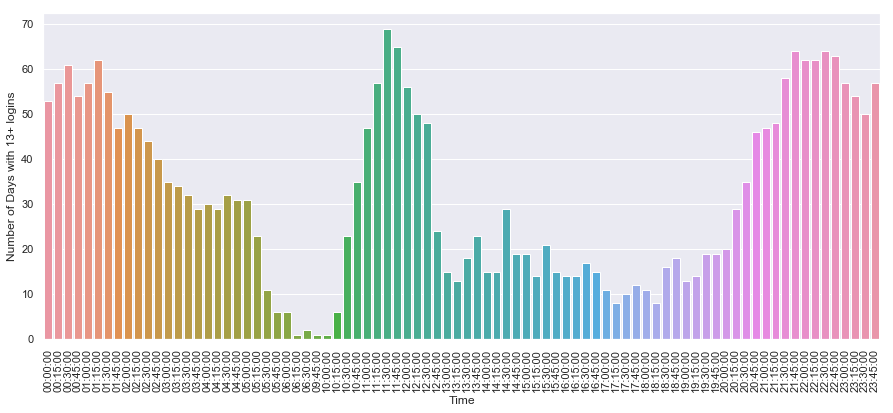

In [15]:
plt.figure(figsize=(15,6))
sns.barplot(peak_counts.index, peak_counts.values)
plt.xticks(rotation=90)
plt.xlabel('Time')
plt.ylabel('Number of Days with 13+ logins')
plt.show()

In [16]:
performance = pd.concat(
    [peak_counts, off_peak_counts], join='outer', axis=1, sort=True
).fillna(0)

In [17]:
performance.columns = ['peak', 'off_peak']

In [18]:
performance.peak = performance.peak.astype(int)

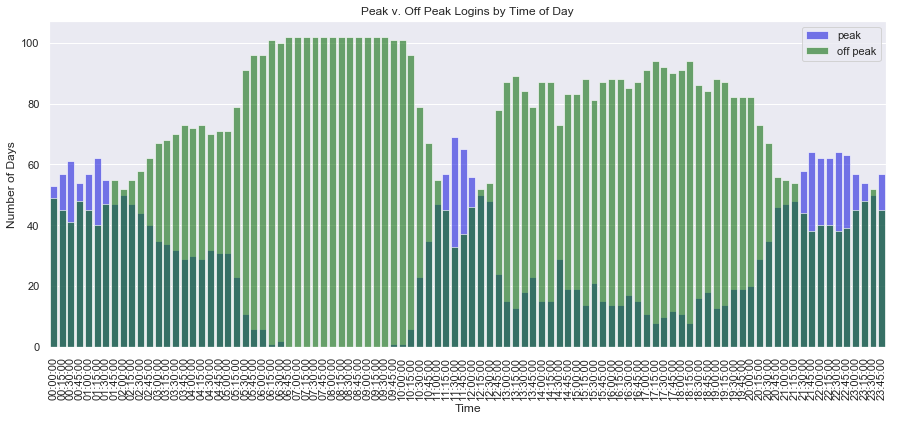

In [19]:
plt.figure(figsize=(15,6))
sns.barplot(performance.index, performance.peak, label='peak', color='blue', alpha=0.6)
sns.barplot(performance.index, performance.off_peak, label='off peak', color='green',
           alpha=0.6)
plt.xticks(rotation=90)
plt.title('Peak v. Off Peak Logins by Time of Day')
plt.xlabel('Time')
plt.ylabel('Number of Days')
plt.legend()
plt.show()

Peak hours by time are 11:15 - 12:00, and 21:30 - 1:30. Does not account for day of the week.

In [20]:
# 0 = monday, 1 = tuesday, etc...
performance_by_day = buckets.groupby(buckets.index.dayofweek).sum()
performance_by_day

,count
login_time,
0,8823
1,9268
2,10339
3,11960
4,15208
5,19377
6,18167


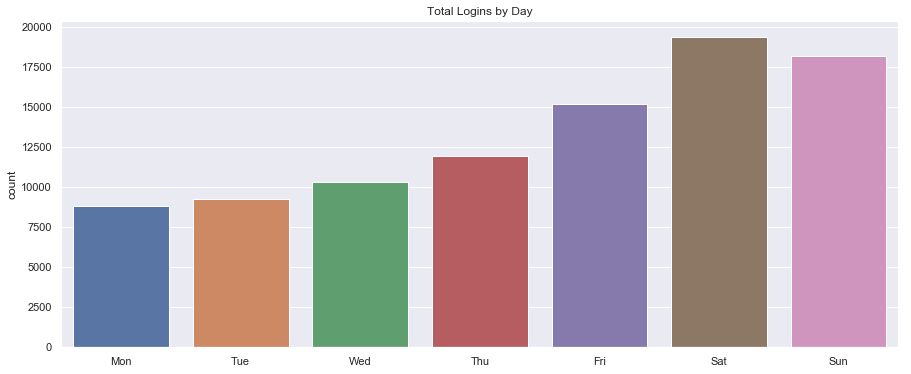

In [21]:
plt.figure(figsize=(15,6))
sns.barplot(performance_by_day.index, 'count', data=performance_by_day)
plt.xticks(range(0,7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('Total Logins by Day')
plt.xlabel('')
plt.show()

Saturday is has the most logins, Monday has the fewest. Logins trend up from Monday to Saturday, then dip slightly on Sunday, likely due to rollover from Saturday night.

In [22]:
def plot_daily_trend(day_int):
    """
    day_int is the integer representing the day of the week per the Pandas Datetimeindex format
    0 = Monday, 1 = Tuesday, etc...
    """
    day = buckets.loc[buckets.index.dayofweek==day_int]
    plt.figure(figsize=(15,6))
    for date in np.unique(day.index.date):
        sns.barplot(np.unique(day.index.time), day.loc[day.index.date==date, 'count'], alpha=0.3)

    plt.title('{} Logins by Time of Day, 1/1970 - 4/1970'.format(np.unique(day.index.day_name())[0]))
    plt.ylabel('Logins')
    plt.xlabel('Time')
    plt.xticks(rotation=90)
    plt.show()

In [23]:
mondays = buckets.loc[buckets.index.dayofweek==0]

Need to add 0s to the start and end of the dataframe so the data can be plotted.

In [24]:
missing_start = pd.date_range('1970-01-01 00:00:00', '1970-01-01 19:45:00', freq='15min')

In [25]:
# add the missing time for Thursday, 1/1/1970 to the start of the dataframe
buckets = pd.DataFrame(np.zeros(len(missing_start)), index=missing_start, columns=['count']).append(buckets)

In [26]:
missing_end = pd.date_range('1970-04-13 19:00:00', '1970-04-13 23:45:00', freq='15min')

In [27]:
# add the missing time for Monday, 4/13/1970 to the end of the dataframe
buckets = buckets.append(pd.DataFrame(np.zeros(len(missing_end)), index=missing_end, columns=['count']))

**note**: *Daily performance is stacked so that the lighter portions represent less frequent occurances and darker areas represent more frequent occurances.*

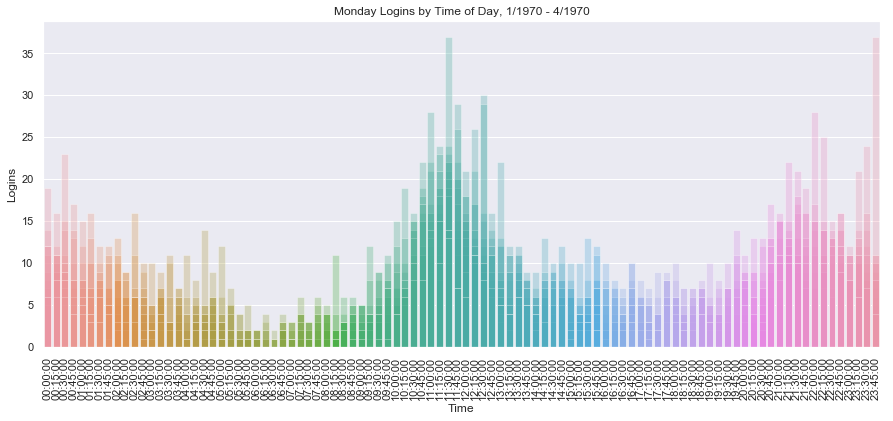

In [28]:
# monday
plot_daily_trend(0)

Monday's performance trend seems to match the daily peak and off peak trend. Higher during lunch hour, and between 9 PM - 1 PM. 

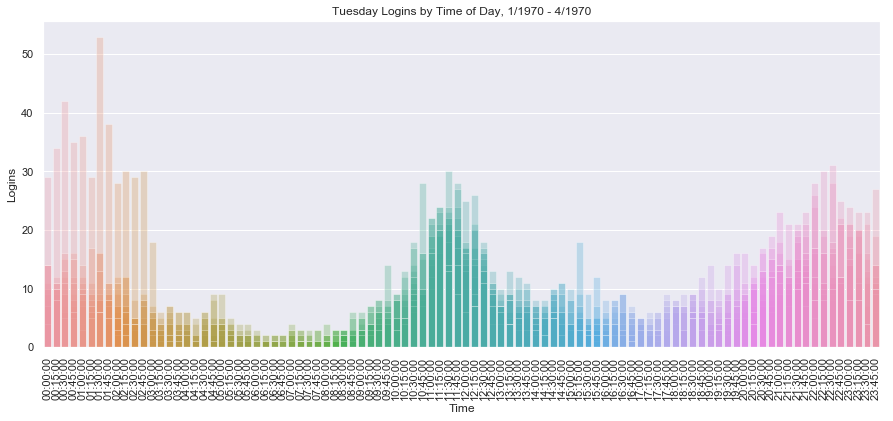

In [29]:
# tuesday
plot_daily_trend(1)

Tuesday generally follows the same trend as Monday; with the exception of 1 day where early tuesday morning had a large spike in logins. Likely due to a holiday or some other event.

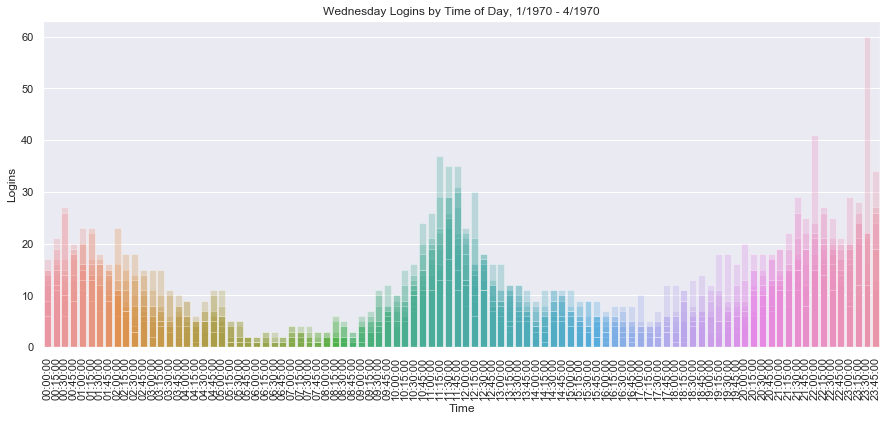

In [30]:
# wednesday
plot_daily_trend(2)

Wednesdays also follow the general weekday pattern. Login spike around noon, another rise in late evening/early morning.

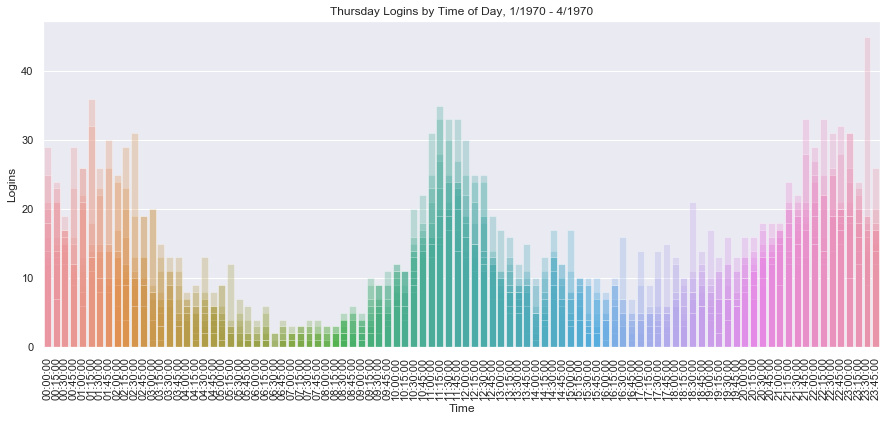

In [31]:
# thursday
plot_daily_trend(3)

Thursday follows the weekly trend; however, it has noticeably more logins during peak hours than Monday, Tuesday, or Wednesday.

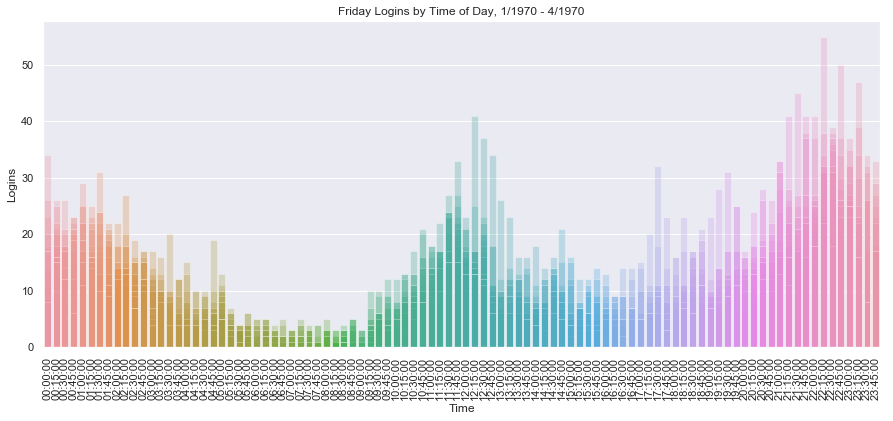

In [32]:
# friday
plot_daily_trend(4)

Fridays follow a similar pattern to the other week days; however, evening logins are much higher than the rest of the week. This evening peak carries over into early Saturday morning, as shown below.

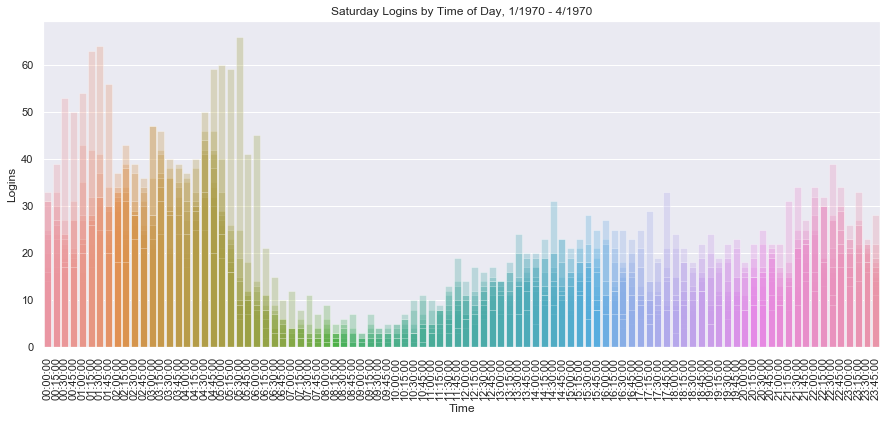

In [33]:
# satruday
plot_daily_trend(5)

Saturday has a very high amount of logins in the early morning, logins dip around 6:15 AM, then come back up around 12 PM and stay between 10-20 logins every 15 min for the rest of the day.

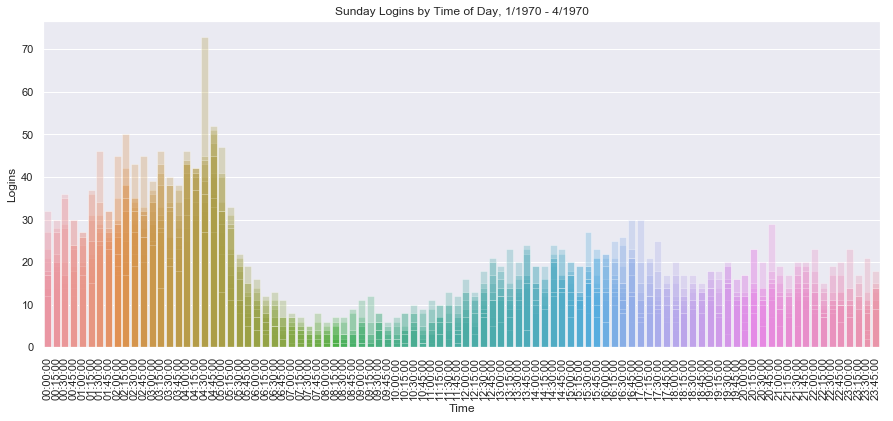

In [34]:
# sunday
plot_daily_trend(6)

Sunday follows a similar patter to Saturday; however, the overall number of logins is lower than Saturday.

## Summary
Peak time is defined as any 15-minute interval where there were 13 or more logins. This is based on the 75th percentile of all 15 minute periods measured in the dataset.

Peak times are generally between 11 AM - 12 PM, and 9:30 PM - 1:45 AM, varying by the day of the week. Mondays, Thursdays, and Fridays have the highest lunch time peaks, compared with Tuesdays and Wednesdays. Weekend evening peak times are much longer than weekday evening peak times. Peak times may be influenced by events not included in the data such as events, or holidays. 

# Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

    a. how you will implement the experiment

    b. what statistical test(s) you will conduct to verify the significance of the
    observation

    c. how you would interpret the results and provide recommendations to the city
    operations team along with any caveats.

## Metric Selection
I would choose profit from trips made accross cities, including trips in one city by a driver from the other city, as my metric of success. I chose this metric because it would most accurately represent the increase in revenue offset by the amount of tolls paid. If profits increase despite the company reimbursing all toll costs, it is advisable that this experiment was a success, and should be implemented as standard practice.

## Experiment Design
### Experiment Implementation
I would implement the experiment in the form of an A/B test. First, randomly select drivers to participate in the program, then compare the profit from those rides against the profit from the control group who do not receive toll reimbursement. 
### Statistical Tests
I would use a $t$-test to verify the significance of the difference in profit from the test and control groups.
### Results and Recommendations
If the statistical tests show that the difference in profit is significant, I would recommend that the city operations team expand this program to all drivers in both cities.

# Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

**Data description**

● city: city this user signed up in

● phone: primary device for this user

● signup_date: date of account registration; in the form ‘YYYYMMDD’

● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● avg_rating_by_driver: the rider’s average rating over all of their trips

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

● surge_pct: the percent of trips taken with surge multiplier > 1

● avg_surge: The average surge multiplier over all of this user’s trips

● trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise

● weekday_pct: the percent of the user’s trips occurring during a weekday


## Data Wrangling & Exploratory Data Analysis

In [35]:
import json
with open('ultimate_data_challenge.json') as json_file:
    data = json.load(json_file)

In [36]:
df = pd.DataFrame(data)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [37]:
# convert last trip date and signup date columns to datetime data type
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)

In [38]:
# create retained column: 1 if last trip in 6th month (signup date + 5 months) from sign up date, else 0
from datetime import date
from dateutil.relativedelta import relativedelta
df['retained'] = df.apply(lambda x: 1 if x.last_trip_date > x.signup_date + relativedelta(months=+5) else 0,
                         axis=1)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
retained                  50000 non-null int64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(2), object(2)
memory usage: 4.6+ MB


In [40]:
df.avg_rating_by_driver.fillna(np.mean(df.avg_rating_by_driver), inplace=True)

In [41]:
df.avg_rating_of_driver.fillna(np.mean(df.avg_rating_of_driver), inplace=True)

In [42]:
df.dropna(inplace=True)

In [43]:
# binarize phone column - 1: iPhone, 0: Android
df.phone = df.phone.apply(lambda x: 1 if x == 'iPhone' else 0)

In [44]:
# create dummy variables for the city names
df['kings_landing'] = df.city.apply(lambda x: 1 if x == "King's Landing" else 0)

df['astapor'] = df.city.apply(lambda x: 1 if x == 'Astapor' else 0)

df['winterfell'] = df.city.apply(lambda x: 1 if x == 'Winterfell' else 0)

# drop the city column
df.drop('city', axis=1, inplace=True)

In [45]:
# drop date columns, they are now represented by 'retained'
df.drop(['signup_date', 'last_trip_date'], axis=1, inplace=True)

In [46]:
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,phone,surge_pct,trips_in_first_30_days,weekday_pct,retained,kings_landing,astapor,winterfell
count,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000
mean,5.785418,4.777862,4.601482,1.074991,0.697162,8.875314,2.277256,60.883832,0.234457,0.202927,0.330881,0.466192
std,5.669709,0.446220,0.565227,0.222666,0.459491,19.989018,3.793300,37.086239,0.423663,0.402183,0.470535,0.498861
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.500000,1.000000,0.000000,0.000000,0.000000,33.300000,0.000000,0.000000,0.000000,0.000000
50%,3.880000,5.000000,4.700000,1.000000,1.000000,0.000000,1.000000,66.700000,0.000000,0.000000,0.000000,0.000000
75%,6.930000,5.000000,5.000000,1.050000,1.000000,8.700000,3.000000,100.000000,0.000000,0.000000,1.000000,1.000000
max,160.960000,5.000000,5.000000,8.000000,1.000000,100.000000,125.000000,100.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
df.groupby('phone')['retained'].mean()

phone
0    0.122287
1    0.283182
Name: retained, dtype: float64

In [48]:
df.groupby('retained')['avg_rating_of_driver'].mean()

retained
0    4.604286
1    4.592328
Name: avg_rating_of_driver, dtype: float64

In [49]:
df.groupby('retained')['avg_rating_by_driver'].mean()

retained
0    4.783290
1    4.760138
Name: avg_rating_by_driver, dtype: float64

In [50]:
corr = df.corr()

In [51]:
retained = corr['retained'].drop('retained')

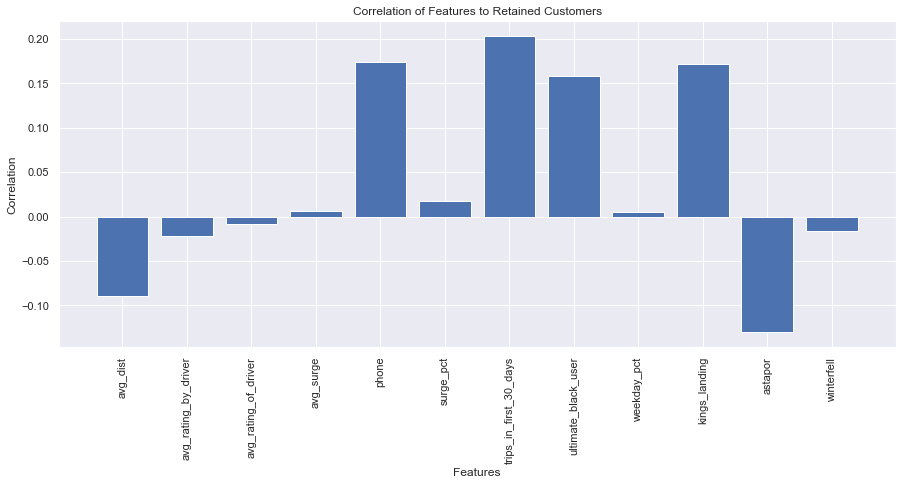

In [52]:
plt.figure(figsize=(15,6))
plt.bar(range(len(retained)), retained)
plt.xticks(range(len(retained)), retained.index, rotation=90)
plt.title('Correlation of Features to Retained Customers')
plt.ylabel('Correlation')
plt.xlabel('Features')
plt.show()

There were some NaN values in the phone and ratings columns. The ratings columns were filled with the average so that the remaining data in those rows could be kept without influencing the mean of the data in those columns; however, the rows with NaN in the phone column were dropped. Additionally, the city column was changed to 3 dummy variables for each value so that the correlation to retention could be calculated. The date columns were dropped because they will not be needed for this analysis.

From the resulting dataset, 23.45% of the customers were retained. The plot above shows the correlation for each of the remaining features in regards to retention. It is interesting to note that iPhone users have a higher retention rate than Android users. It is interesting to note that both ratings columns are negatively correlated to retention. Additionaly, average distance is also strongly (in relation to other correlations) negatively correlated to retention.

## Predictive Model

### Random Forest Classifier

In [53]:
# import machine learning modules
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_curve

In [54]:
X = df.drop('retained', axis=1)
y = df.retained
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42069)

In [55]:
rf = RandomForestClassifier(random_state=360, class_weight='balanced')
rf = rf.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [56]:
rf_prd = rf.predict(X_test)
rf_prob = rf.predict_proba(X_test)[:, 1]

In [57]:
# compute metrics
rf_cm = confusion_matrix(rf_prd, y_test)
rf_precision = precision_score(rf_prd, y_test)
rf_recall = recall_score(rf_prd, y_test)
rf_accuracy = accuracy_score(rf_prd, y_test)
rf_f1 = f1_score(rf_prd, y_test)

# ROC
rf_tpr, rf_fpr, thresholds = roc_curve(y_test, rf_prob)

confusion matrix
[[10398  2303]
 [ 1029  1152]]

precision score
0.3334298118668596

recall score
0.5281980742778541

accuracy score
0.7761053621825024

f1 score
0.4088005677785663



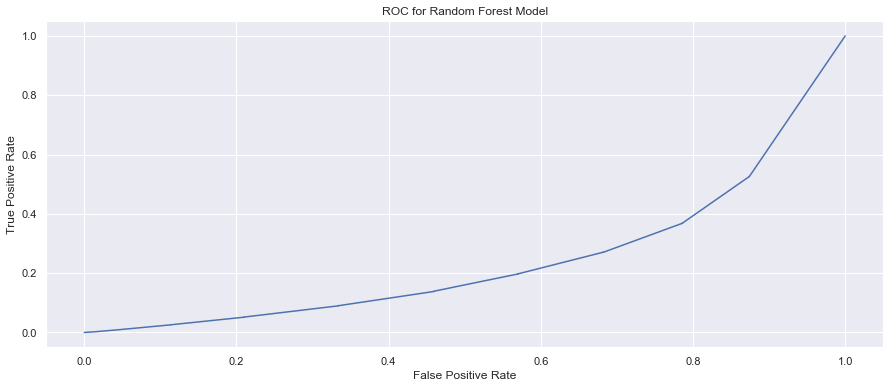

In [58]:
print('confusion matrix')
print(rf_cm)
print('')
print('precision score')
print(rf_precision)
print('')
print('recall score')
print(rf_recall)
print('')
print('accuracy score')
print(rf_accuracy)
print('')
print('f1 score')
print(rf_f1)
print('')

# Plot ROC curve
plt.figure(figsize=(15,6))
plt.plot(rf_fpr, rf_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Random Forest Model')
plt.show()

In [59]:
rf_imp = rf.feature_importances_.tolist()
rf_imp_df = pd.DataFrame({'feature': X_test.columns, 'importance': rf_imp})
rf_imp_df.sort_values(by='importance', ascending = False)

,feature,importance
0,avg_dist,0.300394
8,weekday_pct,0.153637
1,avg_rating_by_driver,0.101159
5,surge_pct,0.099335
2,avg_rating_of_driver,0.087439
6,trips_in_first_30_days,0.084201
3,avg_surge,0.071930
4,phone,0.028804
9,kings_landing,0.026472
7,ultimate_black_user,0.022209


### Logistic Regression

In [60]:
lr = LogisticRegression(solver='liblinear', class_weight='balanced')
lr = lr.fit(X_train, y_train)

In [61]:
lr_prd = lr.predict(X_test)
lr_prob = lr.predict_proba(X_test)[:, 1]

In [62]:
# compute metrics
lr_cm = confusion_matrix(lr_prd, y_test)
lr_precision = precision_score(lr_prd, y_test)
lr_recall = recall_score(lr_prd, y_test)
lr_accuracy = accuracy_score(lr_prd, y_test)
lr_f1 = f1_score(lr_prd, y_test)

# ROC
lr_tpr, lr_fpr, thresholds = roc_curve(y_test, lr_prob)

confusion matrix
[[7873 1130]
 [3554 2325]]

precision score
0.6729377713458755

recall score
0.3954754209899643

accuracy score
0.6852573578820051

f1 score
0.49817870152131993



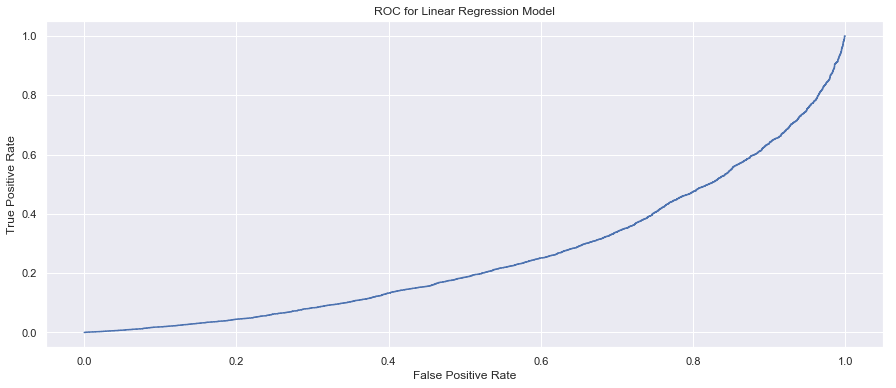

In [63]:
print('confusion matrix')
print(lr_cm)
print('')
print('precision score')
print(lr_precision)
print('')
print('recall score')
print(lr_recall)
print('')
print('accuracy score')
print(lr_accuracy)
print('')
print('f1 score')
print(lr_f1)
print('')

# Plot ROC curve
plt.figure(figsize=(15,6))
plt.plot(lr_fpr, lr_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Linear Regression Model')
plt.show()

In [64]:
lr_imp = lr.coef_.tolist()
lr_imp_df = pd.DataFrame({'feature': X_test.columns, 'coefficient': lr_imp[0]})
lr_imp_df.sort_values(by='coefficient', ascending = False)

,feature,coefficient
4,phone,0.966715
9,kings_landing,0.660950
7,ultimate_black_user,0.650682
6,trips_in_first_30_days,0.105329
5,surge_pct,0.003344
8,weekday_pct,-0.000310
0,avg_dist,-0.045850
2,avg_rating_of_driver,-0.046396
11,winterfell,-0.067197
3,avg_surge,-0.130081


In [65]:
# grid search cross validation to see if we can improve the model
from sklearn.model_selection import GridSearchCV
parameters = {'penalty': ('l1', 'l2'), 'C': [.01, .1, 1, 10]}
lr = LogisticRegression(solver='liblinear', class_weight='balanced')
lr_grid = GridSearchCV(lr, parameters, cv=5)
lr_grid = lr_grid.fit(X_train, y_train)
lr_grid_prd = lr_grid.predict(X_test)
lr_grid_prob = lr_grid.predict_proba(X_test)[:, 1]

In [66]:
lr_grid.best_params_

{'C': 0.01, 'penalty': 'l2'}

In [67]:
# compute metrics
lr_grid_cm = confusion_matrix(lr_grid_prd, y_test)
lr_grid_precision = precision_score(lr_grid_prd, y_test)
lr_grid_recall = recall_score(lr_grid_prd, y_test)
lr_grid_accuracy = accuracy_score(lr_grid_prd, y_test)
lr_grid_f1 = f1_score(lr_grid_prd, y_test)

# ROC
lr_grid_tpr, lr_grid_fpr, thresholds = roc_curve(y_test, lr_grid_prob)

confusion matrix
[[7889 1145]
 [3538 2310]]

precision score
0.6685962373371924

recall score
0.39500683994528046

accuracy score
0.6853245531514581

f1 score
0.4966139954853273



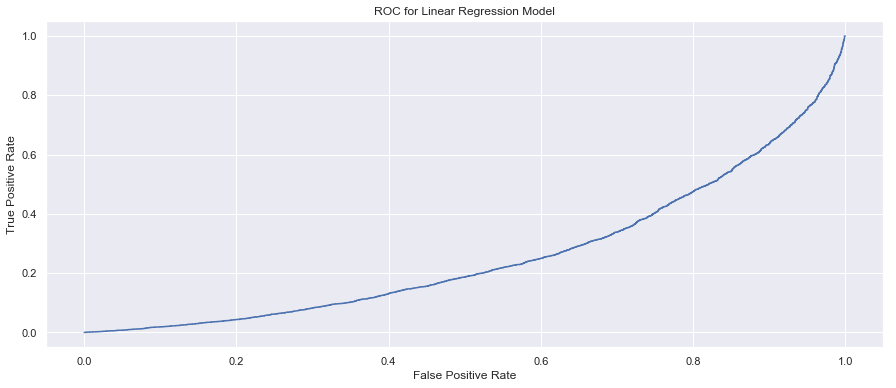

In [68]:
print('confusion matrix')
print(lr_grid_cm)
print('')
print('precision score')
print(lr_grid_precision)
print('')
print('recall score')
print(lr_grid_recall)
print('')
print('accuracy score')
print(lr_grid_accuracy)
print('')
print('f1 score')
print(lr_grid_f1)
print('')

# Plot ROC curve
plt.figure(figsize=(15,6))
plt.plot(lr_grid_fpr, lr_grid_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Linear Regression Model')
plt.show()

My approach was to train a default random forest classifier and logistic regression model to compare the results. Random forest classifiers work well out of the bag with default settings, as do logistic regression models. I also considered using a SVM, but decided against it as it may require more advanced hyperparameter tuning. 

The random forest model had a higher f1 score than the logistic regression model; however, the logistic regression model had a lower number of false positives which, given the use case, is more important than an overall higher f1 score since we are trying to detect the non-retained customers. The logistic regression model does have a very large number of false negatives, but since these are customers that are actually retained this should not be a concern. Based on the ROC curves, neither of these models are performed better than random chance.

### Insights

Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

Based on the model predictions, Ultimate could target customers identifed by the model as 'not retained' with offers to help keep them active in the system. Alternatively, it could also use the information produced from the exploratory data analysis to target certain cities with offers to increase customer interactions. 